In [1]:
import sys
sys.path.append('..')

In [2]:
import torch
import pickle
import yaml
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sklearn

from torch.utils.data.dataloader import DataLoader
from reaction_predictors.graph_model.models import RGCNNTrClassifier
from utils.graph_utils import get_bonds, get_nodes
from utils.torch_dataset import Dataset, graph_collate
from utils.draw_utils import draw_gt_reaction
from utils.dataset_utils import prune_dataset_by_length
from reaction_predictors.graph_model.model_utils import train_epoch, evaluate, test
from collections import namedtuple
from sklearn.cluster import KMeans
from MulticoreTSNE import MulticoreTSNE as TSNE
from rdkit.Chem.Draw import rdMolDraw2D
from rdkit.Chem.Draw import IPythonConsole
from IPython.display import SVG, Image
from collections import Counter, OrderedDict

from scipy.spatial.distance import cosine
from IPython.display import display

IPythonConsole.molSize = (300,300)

RDKit WARNING: [11:55:40] Enabling RDKit 2019.09.3 jupyter extensions


In [3]:
def convert(dictionary):
    for key, value in dictionary.items():
        if isinstance(value, dict):
            dictionary[key] = convert(value)
    return namedtuple('GenericDict', dictionary.keys())(**dictionary)

In [4]:
with open('../scripts/graph_models/MT_EGTBF_150.yml', 'r') as ymlfile:
    config = yaml.load(ymlfile, Loader=yaml.FullLoader)

In [5]:
device = 'cuda:0'
model_cfg = convert(config["model"])
data_cfg = convert(config["dataset"])
train_cfg = convert(config["train"])
paths = convert(config["paths"])

In [6]:
meta = pickle.load(open(paths.dataset_path + 'meta.pkl', 'rb'))

node2label = get_nodes(meta['node'], n_molecule_level=data_cfg.n_molecule_level,
                       n_reaction_level=data_cfg.n_reaction_level)
bond2label = get_bonds(meta['type'], n_molecule_level=data_cfg.n_molecule_level,
                       n_reaction_level=data_cfg.n_reaction_level,
                       self_bond=data_cfg.self_bond)

In [7]:
num_rels = len(bond2label)
pad_length = data_cfg.max_num_atoms + 15 * data_cfg.n_molecule_level + \
             data_cfg.n_molecule_level * data_cfg.n_reaction_level
num_nodes = pad_length

In [8]:
model =torch.load(paths.save_path, map_location=device)
model = model.to(device)

In [9]:
test_dataset = pickle.load(open('../data/USPTO_50k/dataset.pkl', 'rb'))
test_dataset = prune_dataset_by_length(test_dataset, data_cfg.max_num_atoms)
ts_dataset = Dataset(test_dataset, device=device, pad_length=pad_length,
                         bond2label=bond2label, node2label=node2label, feature_idxs=data_cfg.feature_idxs,
                         target_main_product=data_cfg.target_main_product, target_center=data_cfg.target_center,
                         n_molecule_level=data_cfg.n_molecule_level, n_reaction_level=data_cfg.n_reaction_level)
test_loader = DataLoader(ts_dataset, train_cfg.batch_size, drop_last=True, collate_fn=graph_collate)

In [10]:
classes = [test_dataset[idx]['class'] for idx in test_dataset]

In [11]:
evaluate(model, test_loader)
pass

Main product mapping was done with 0.9962655136127263 F1-measure and 0.9012083866837388 full-match accuracy
Detection of cenetr of reaction was done with 0.9277023592848651 F1-measure and 0.8360675416133163 full-match accuracy


In [12]:
model.eval()
representations = []
with torch.no_grad():
    for batch in test_loader:
        g = batch[0]
        h = model.embed(g.ndata['feats'].T)
        g.ndata['h'] = h
        for layer in model.rgcn.layers[:-1]:
            layer(g)
        h = g.ndata['h'].view((model.batch_size, model.n_nodes, model.h_dim))
        representations.append(h.cpu().detach().numpy())
reac_reps = np.concatenate(representations)

In [13]:
id2hidden = dict(zip(test_dataset.keys(), reac_reps))

In [14]:
reac_reps = []
id2reac = {}
for idx in id2hidden:
    n_atoms = len(test_dataset[idx]['reactants']['nodes'])
    n_molecules = len(test_dataset[idx]['reactants']['lengths']) - 1
    reac_reps.append(id2hidden[idx][n_atoms+n_molecules])
    id2reac[idx] = id2hidden[idx][n_atoms+n_molecules]
reac_reps = np.stack(reac_reps)

In [15]:
classes = classes[:len(reac_reps)]
class2count = OrderedDict(Counter(classes).most_common(10))
classes = np.array(classes)

In [16]:
class_names = {1: 'Heteroatom alkilation\n and arylation',
               2: 'Acylation and\n related processes', 
               3: 'C-C bond formation', 
               4: 'Heterocycle formation', 
               5: 'Protections', 
               6: 'Deprotections', 
               7: 'Reduction', 
               8: 'Oxidation', 
               9: 'Functional group\n interconversation', 
               10: 'Functioanal group\n adding'}

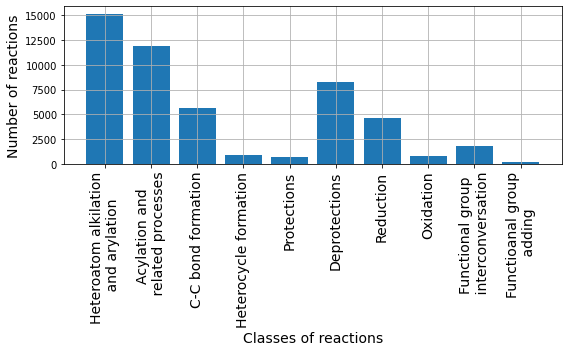

In [17]:
plt.figure(figsize=(8, 5))
plt.bar(list(class2count.keys()), list(class2count.values()), align='center', width = 0.8)
plt.grid()
plt.xlabel('Classes of reactions', fontsize=14)
plt.ylabel('Number of reactions', fontsize=14)
plt.xticks(list(class_names.keys()), list(class_names.values()), rotation='vertical',  fontsize=14)
plt.tight_layout()
plt.savefig('class_dist.png', dpi=300)
plt.show()

In [18]:
minor_idx = [4, 5, 8, 9, 10]
main_idx = [1, 2, 3, 6, 7]
minor_cls = classes[np.isin(classes, minor_idx)]
main_cls = classes[np.isin(classes, main_idx)]
reac_reps_main = reac_reps[np.isin(classes, main_idx)]
reac_reps_minor = reac_reps[np.isin(classes, minor_idx)]

In [19]:
full_2d = TSNE(n_jobs=20, n_iter=500).fit_transform(reac_reps)

In [20]:
main_2d = TSNE(n_jobs=20, n_iter=500).fit_transform(reac_reps_main)
minor_2d = TSNE(n_jobs=20, n_iter=500).fit_transform(reac_reps_minor)

In [54]:
back = '#aaaaaa'
minor_colors = {8: '#173f5f', 4: '#20639b', 5: '#3caea3', 9: '#f6d55c', 10: '#ed553b'}
main_colors = {7: '#173f5f', 2: '#20639b', 6: '#3caea3', 1: '#f6d55c', 3: '#ed553b'}

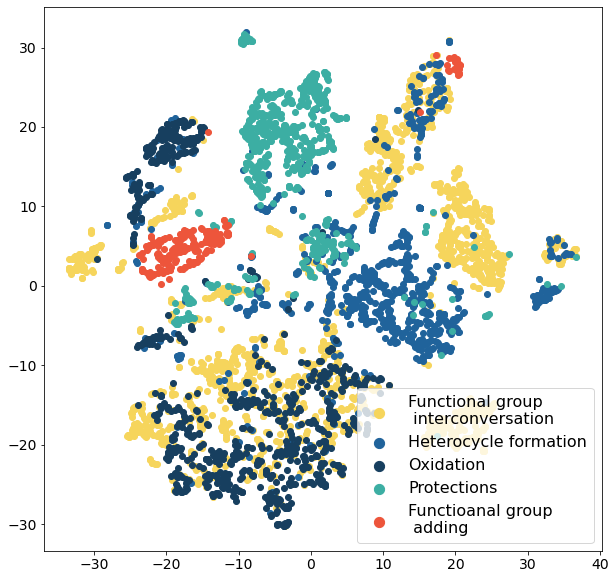

In [57]:
plt.figure(figsize=(10, 10))
scatters = {}
for c in [9, 4,  8, 5, 10]:
    x = minor_2d[:, 0][minor_cls == c]
    y = minor_2d[:, 1][minor_cls == c]
    colors = minor_cls[minor_cls == c]
    scatters[c] = plt.scatter(x, y, c=minor_colors[c])
plt.legend(tuple(scatters.values()), 
          tuple([class_names[i] for i in scatters]), 
          fontsize=16, markerscale=1.7, loc='best', ncol=1)
plt.xticks(fontsize= 14)
plt.yticks(fontsize= 14)
plt.savefig('tsne_minor.png', dpi=300)
plt.show()

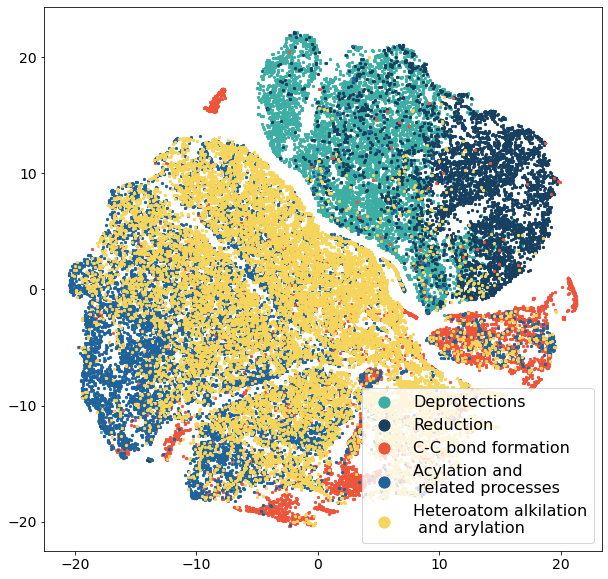

In [71]:
plt.figure(figsize=(10, 10))
scatters = {}
for c in [6, 7, 3, 2, 1]:
    x = main_2d[:, 0][main_cls == c]
    y = main_2d[:, 1][main_cls == c]
    colors = main_cls[main_cls == c]
    scatters[c] = plt.scatter(x, y, c=main_colors[c], s=5)
plt.legend(tuple(scatters.values()), 
          tuple([class_names[i] for i in scatters]), 
          fontsize=16, markerscale=5., loc='lower right')
plt.xticks(fontsize= 14)
plt.yticks(fontsize= 14)
plt.savefig('tsne_main.png', dpi=300)
plt.show()

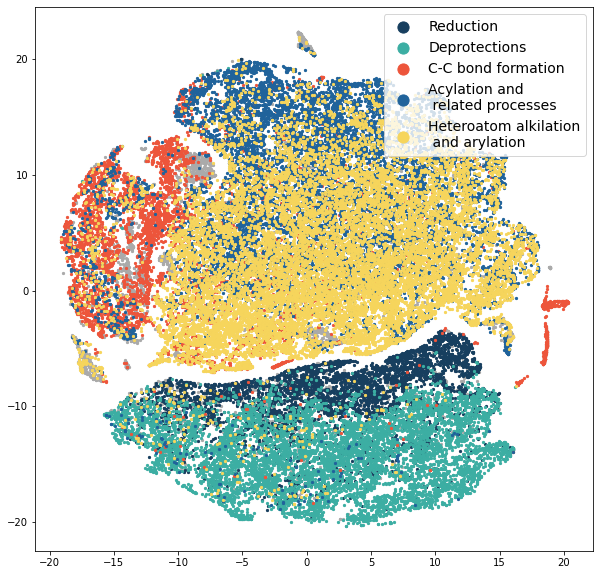

In [31]:
plt.figure(figsize=(10, 10))
scatters = {}
x = full_2d[:, 0][np.isin(classes, minor_idx)]
y = full_2d[:, 1][np.isin(classes, minor_idx)]
plt.scatter(x, y, c=back, s=5)
main_2d = full_2d[np.isin(classes, main_idx)]
for c in [7, 6, 3, 2, 1]:
    x = main_2d[:, 0][main_cls == c]
    y = main_2d[:, 1][main_cls == c]
    colors = main_cls[main_cls == c]
    scatters[c] = plt.scatter(x, y, c=main_colors[c], s=5)
plt.legend(tuple(scatters.values()), 
          tuple([class_names[i] for i in scatters]), 
          fontsize=14, markerscale=5.)
plt.savefig('tsne_main_gray.png', dpi=300)
plt.show()

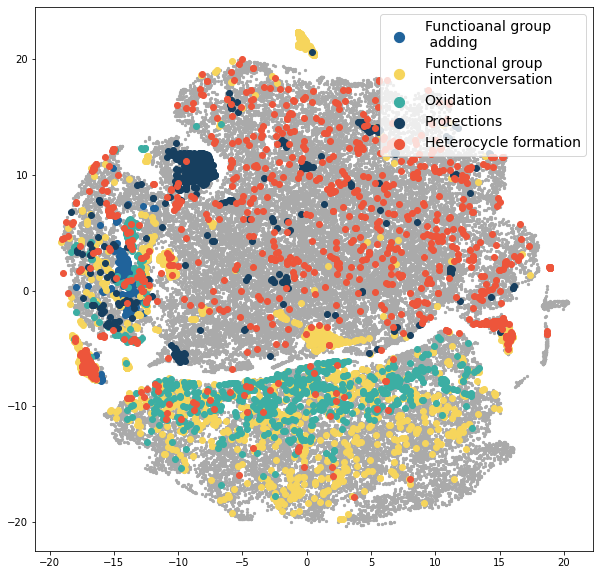

In [32]:
plt.figure(figsize=(10, 10))
scatters = {}
x = full_2d[:, 0][np.isin(classes, main_idx)]
y = full_2d[:, 1][np.isin(classes, main_idx)]
plt.scatter(x, y, c=back, s=5)
minor_2d = full_2d[np.isin(classes, minor_idx)]
for c in [10, 9, 8, 5, 4]:
    x = minor_2d[:, 0][minor_cls == c]
    y = minor_2d[:, 1][minor_cls == c]
    colors = minor_cls[minor_cls == c]
    scatters[c] = plt.scatter(x, y, c=minor_colors[c])
plt.legend(tuple(scatters.values()), 
          tuple([class_names[i] for i in scatters]), 
          fontsize=14, markerscale=1.7)
plt.savefig('tsne_minor_gray.png', dpi=300)
plt.show()

In [33]:
idxs = list(id2hidden.keys())
with open('../data/data_visualisation/original_embeddings.pkl', 'wb') as f:
    pickle.dump(dict(zip(idxs, reac_reps)), f)

In [34]:
def show_k_reactants(dataset, norms, indexes,):
    keys = list(dataset.keys())
    for idx in indexes:
        print(keys[idx])
        print(norms[idx])
        p, r = draw_gt_reaction(dataset[keys[idx]])
        display(SVG(p))
        display(SVG(r))

In [35]:
idxs = [0, 102, 31514]#0, 88, 23890

In [36]:
IPythonConsole.molSize = (500,500)

In [37]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

23890
0.0


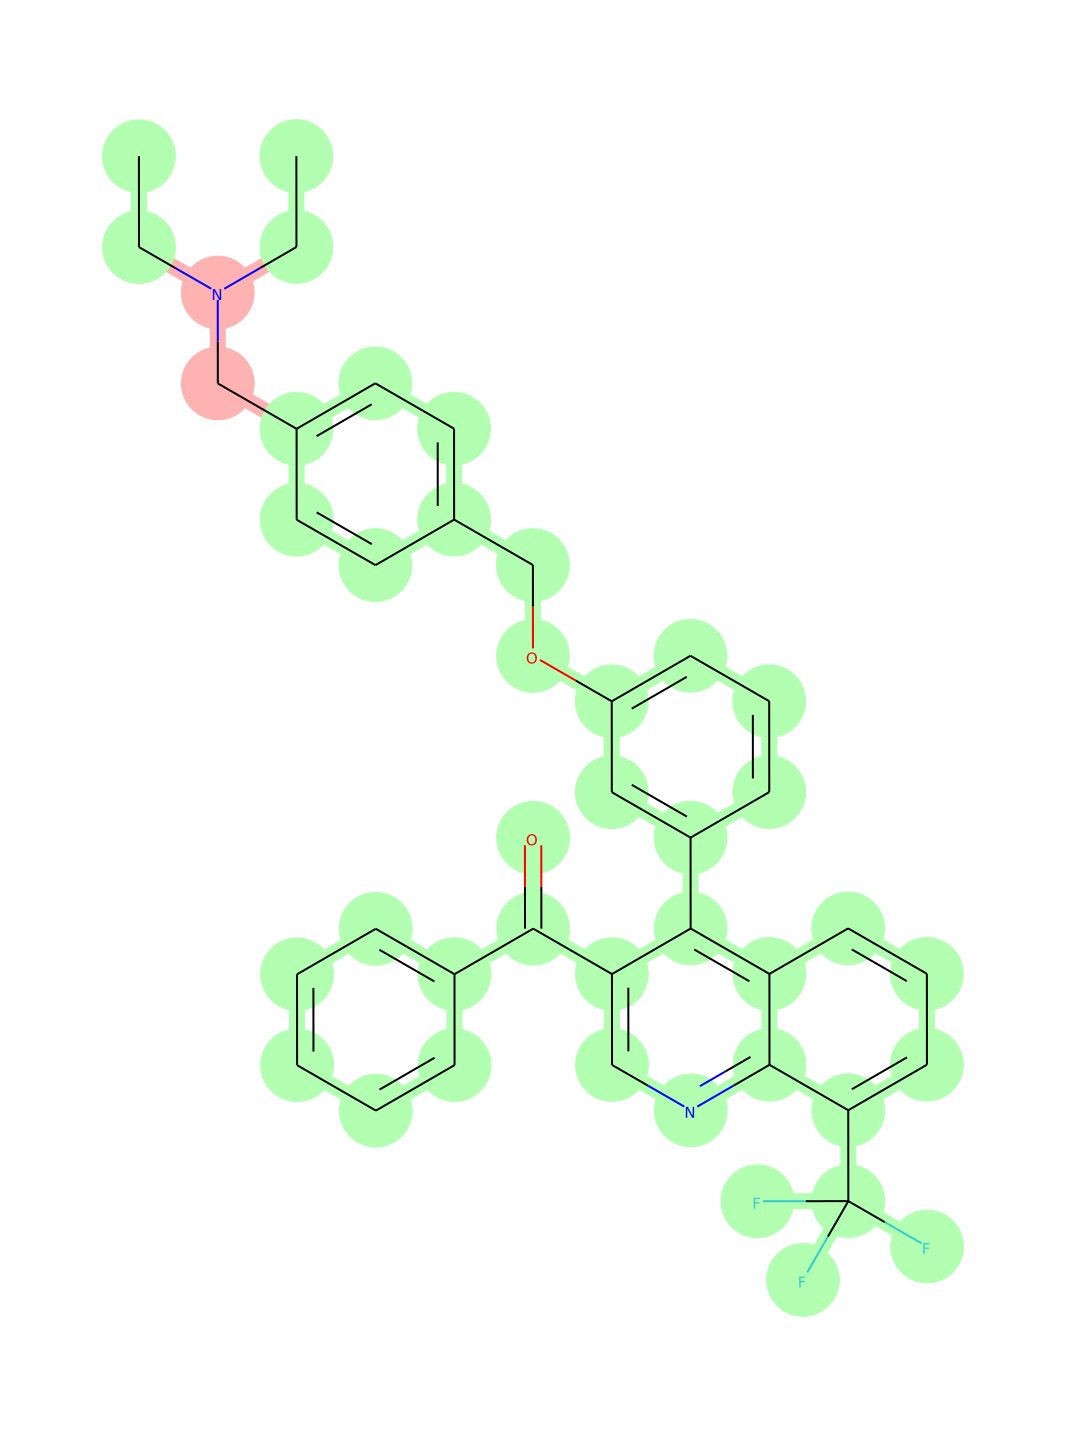

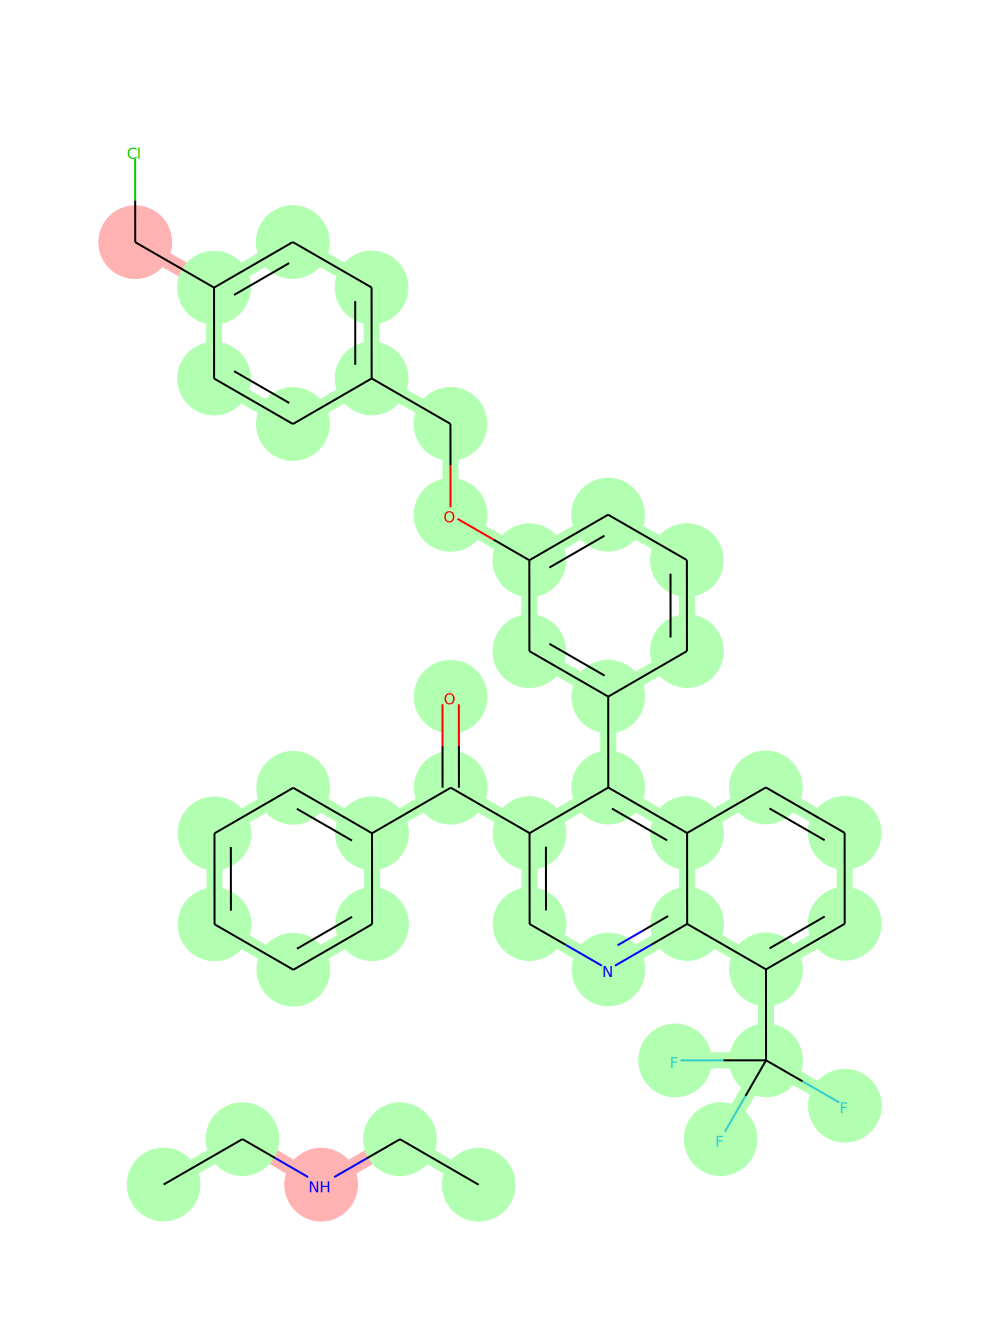

37871
0.12619622


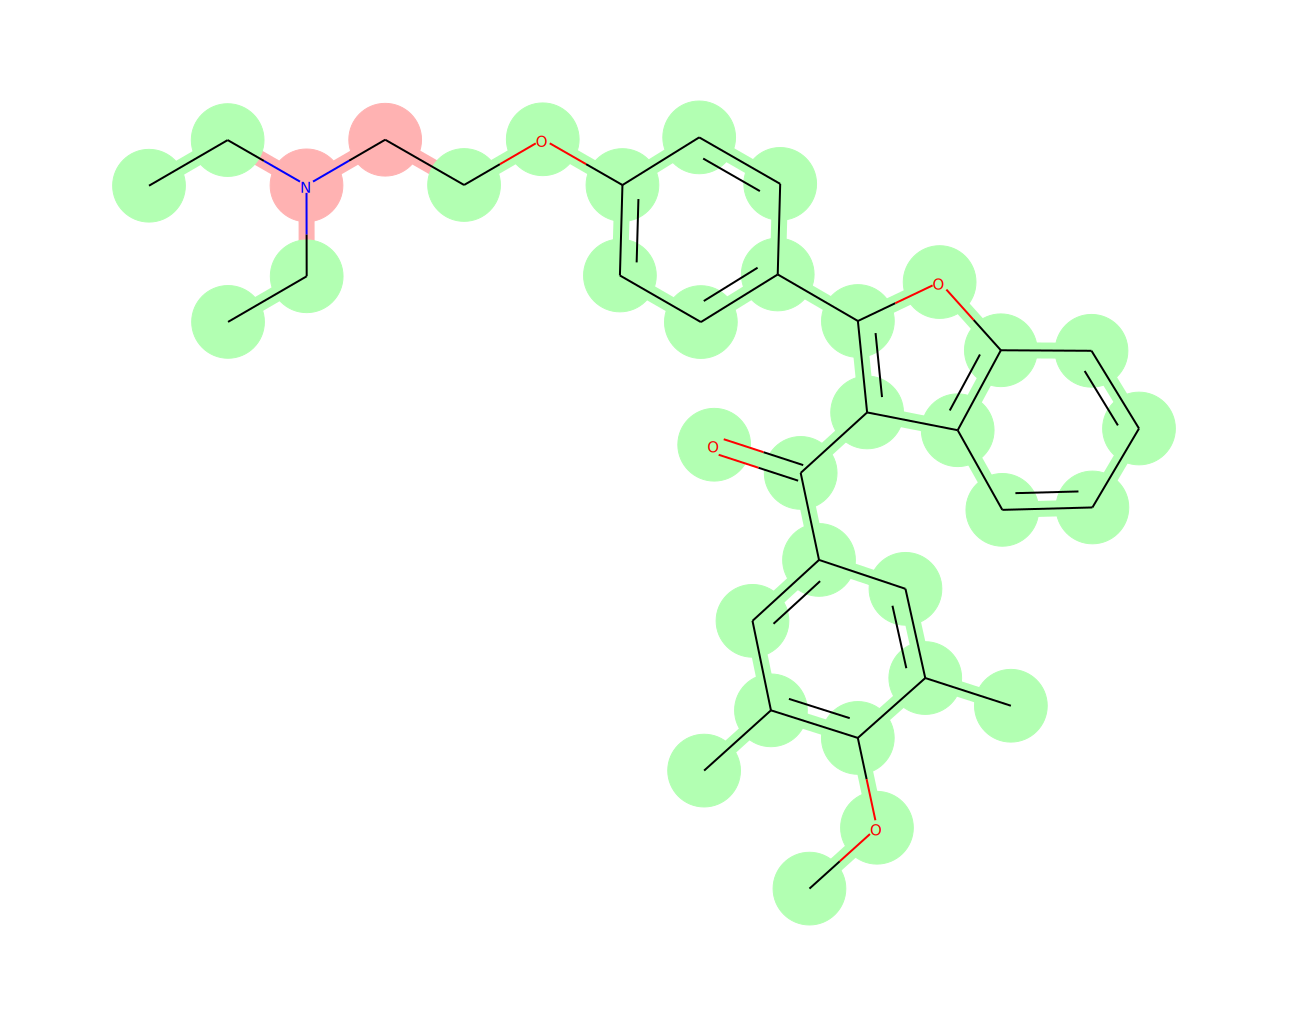

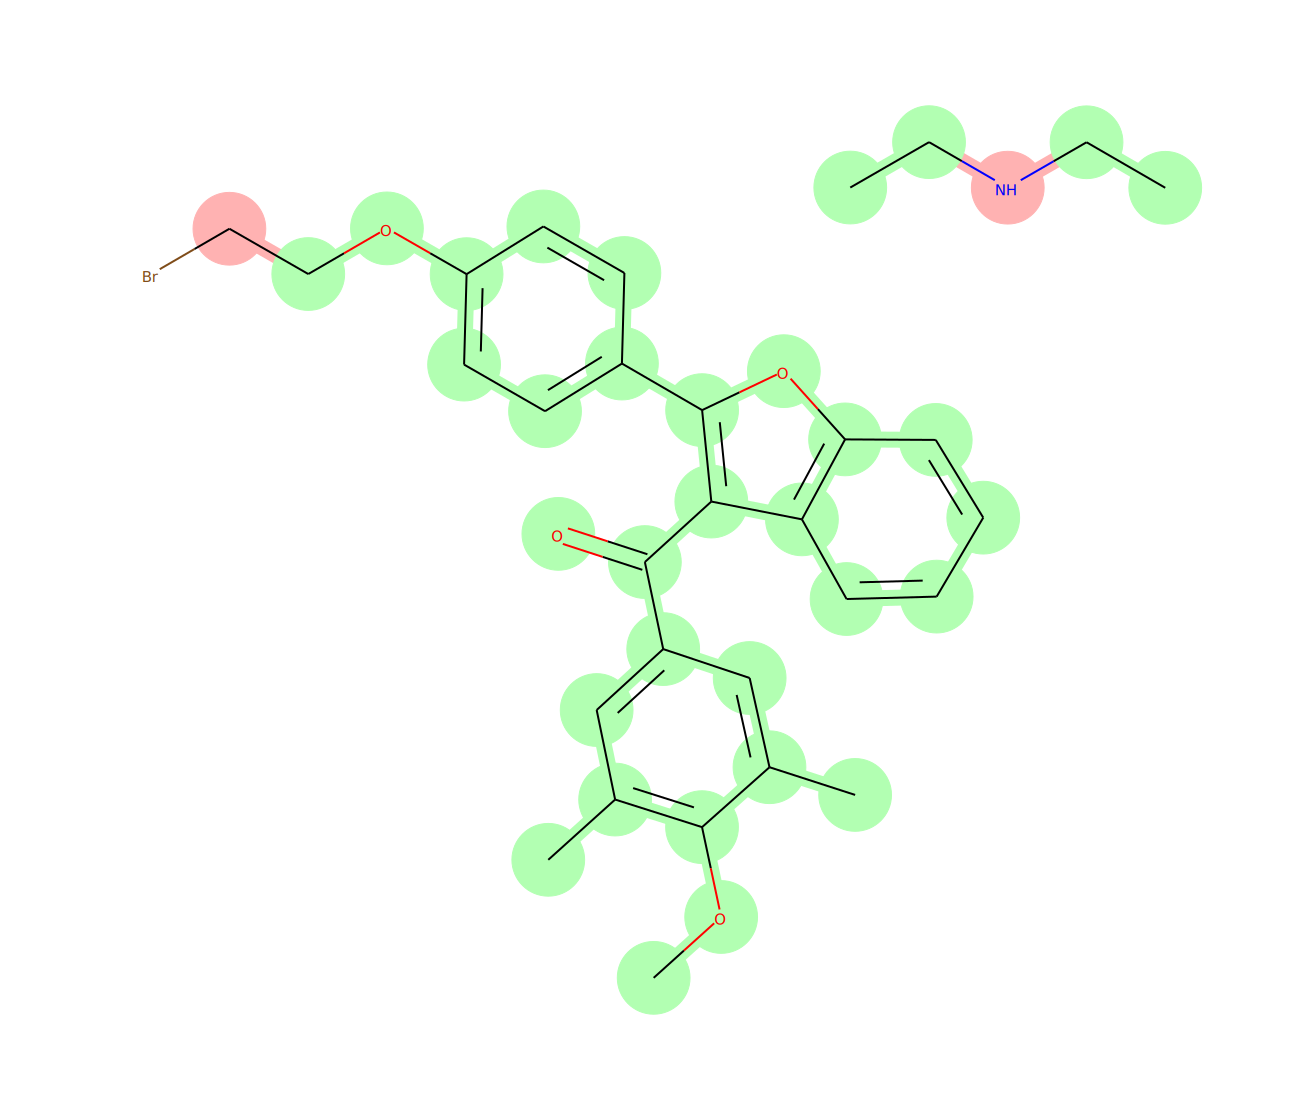

38635
0.1343671


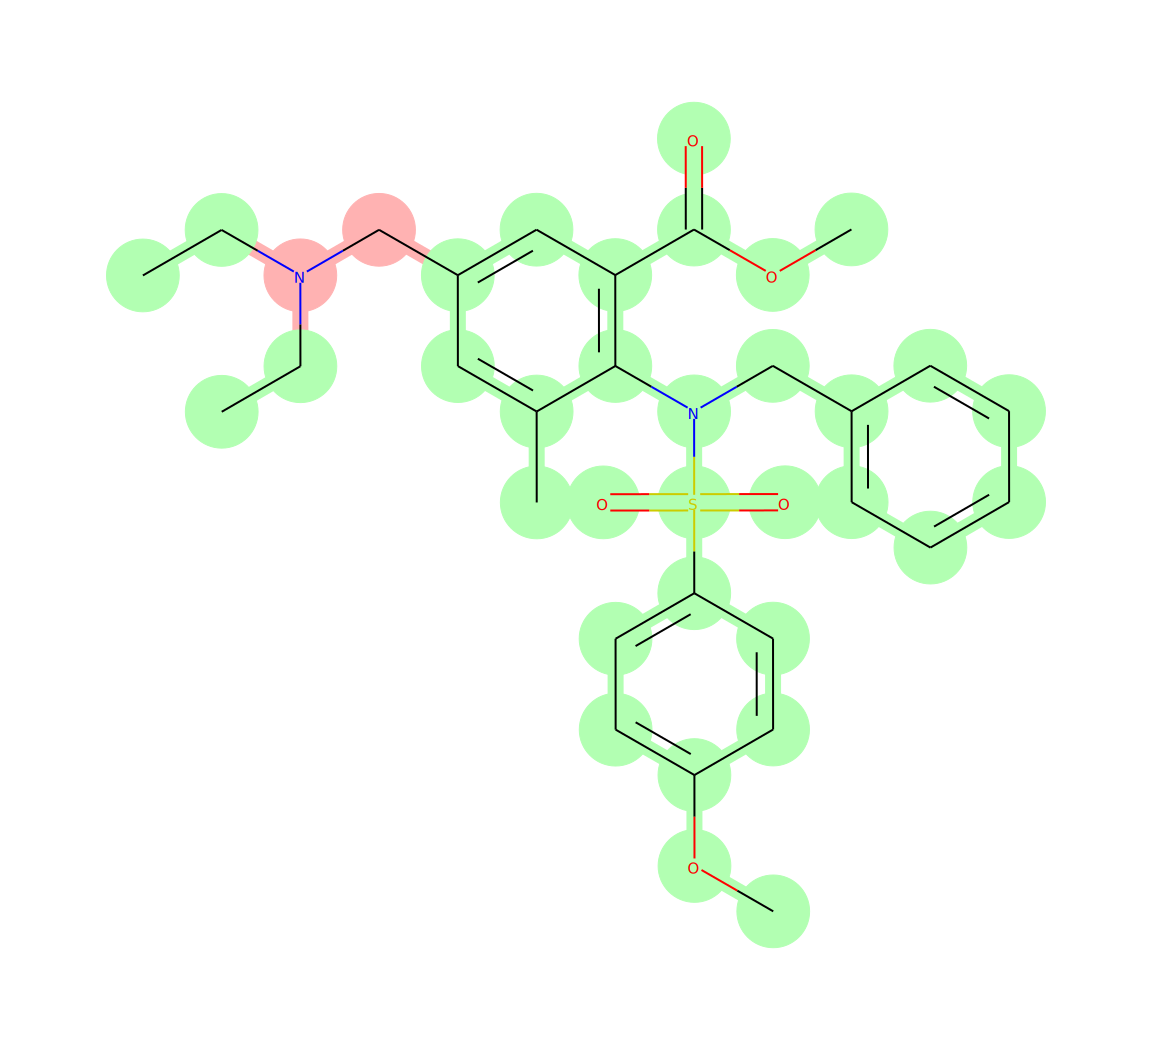

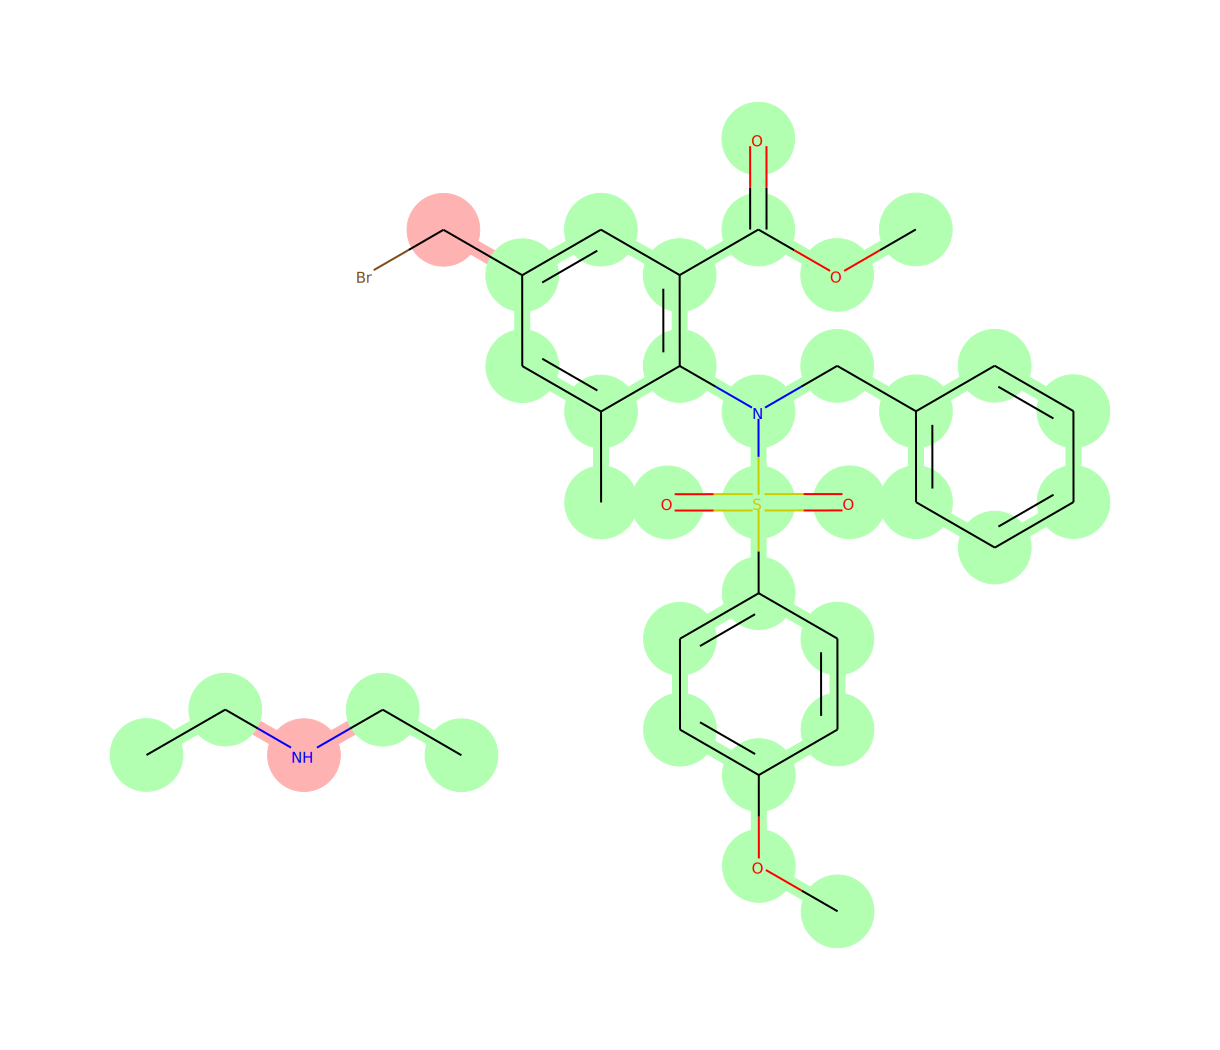

46727
0.25044122


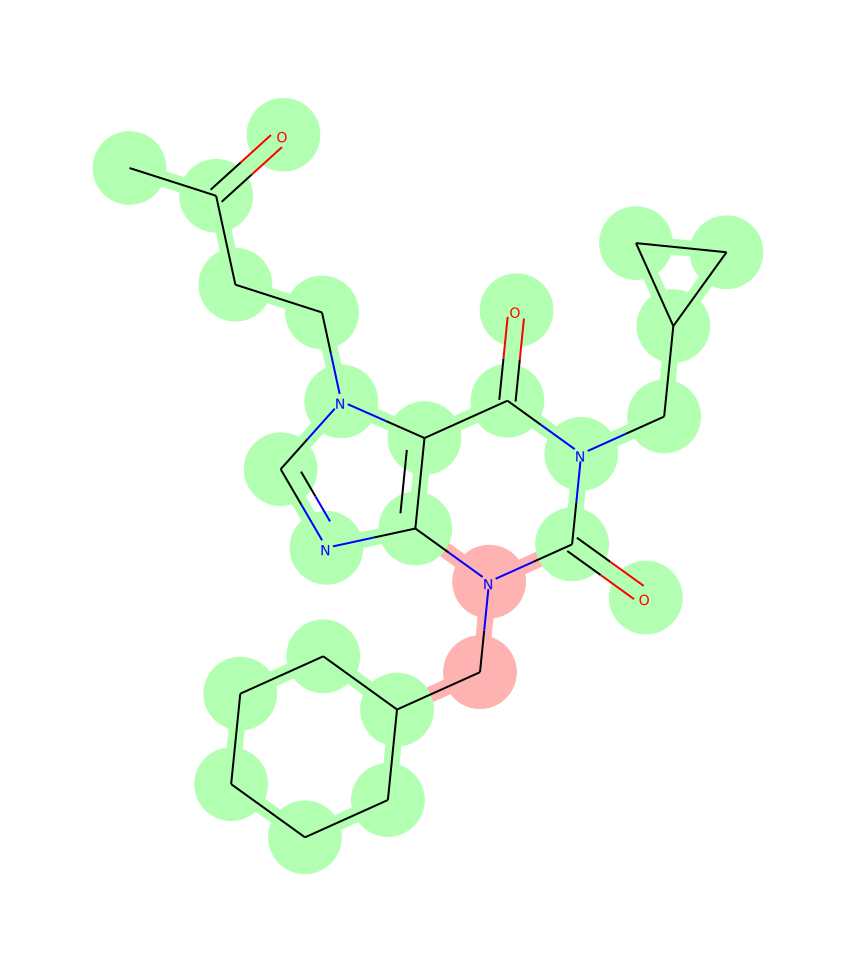

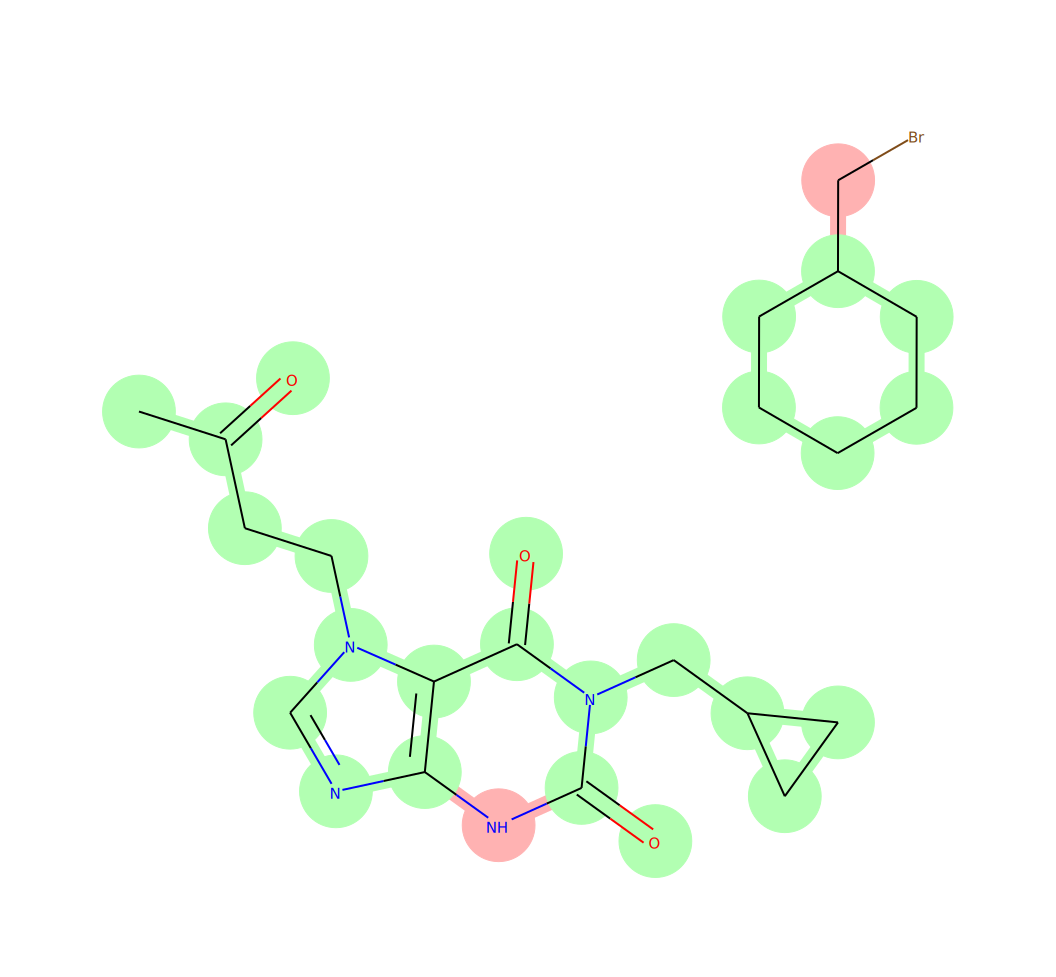

44789
0.73256546


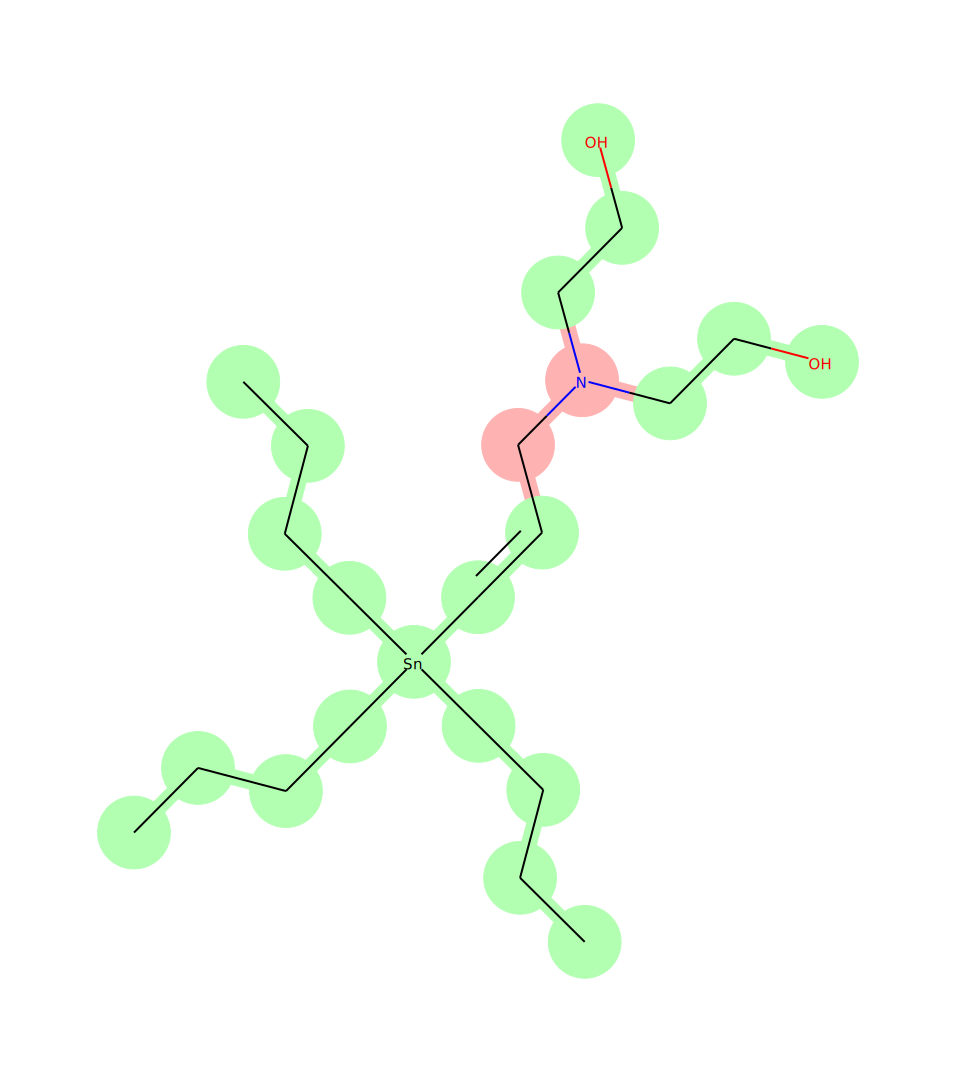

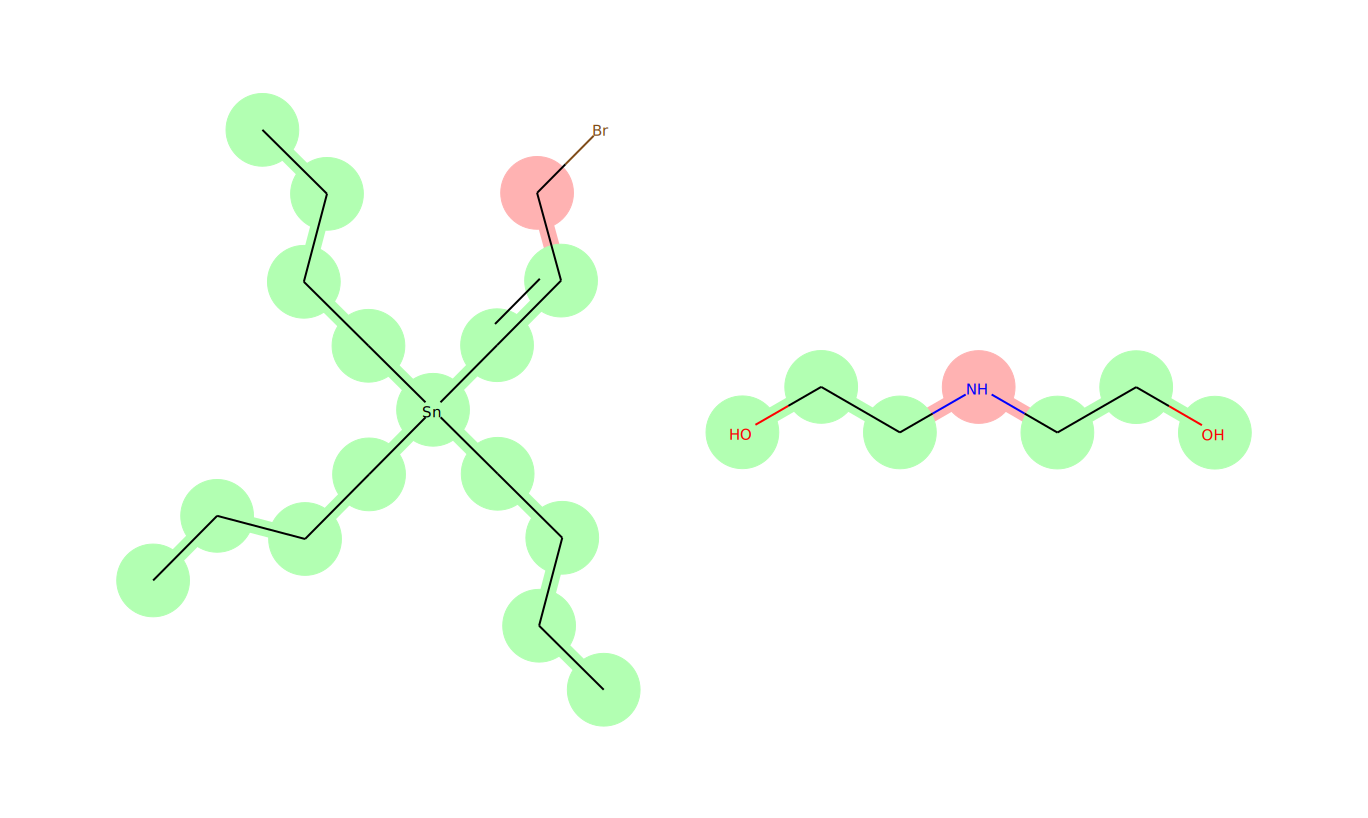

In [38]:
idx = 23890
norms = np.linalg.norm(reac_reps - reac_reps[idx], axis=-1)
norms = np.array(norms)
idxs = np.argsort(norms)
show_k_reactants(test_dataset, norms, idxs[[0, 1, 2, 50, 5002]])

0
0.0


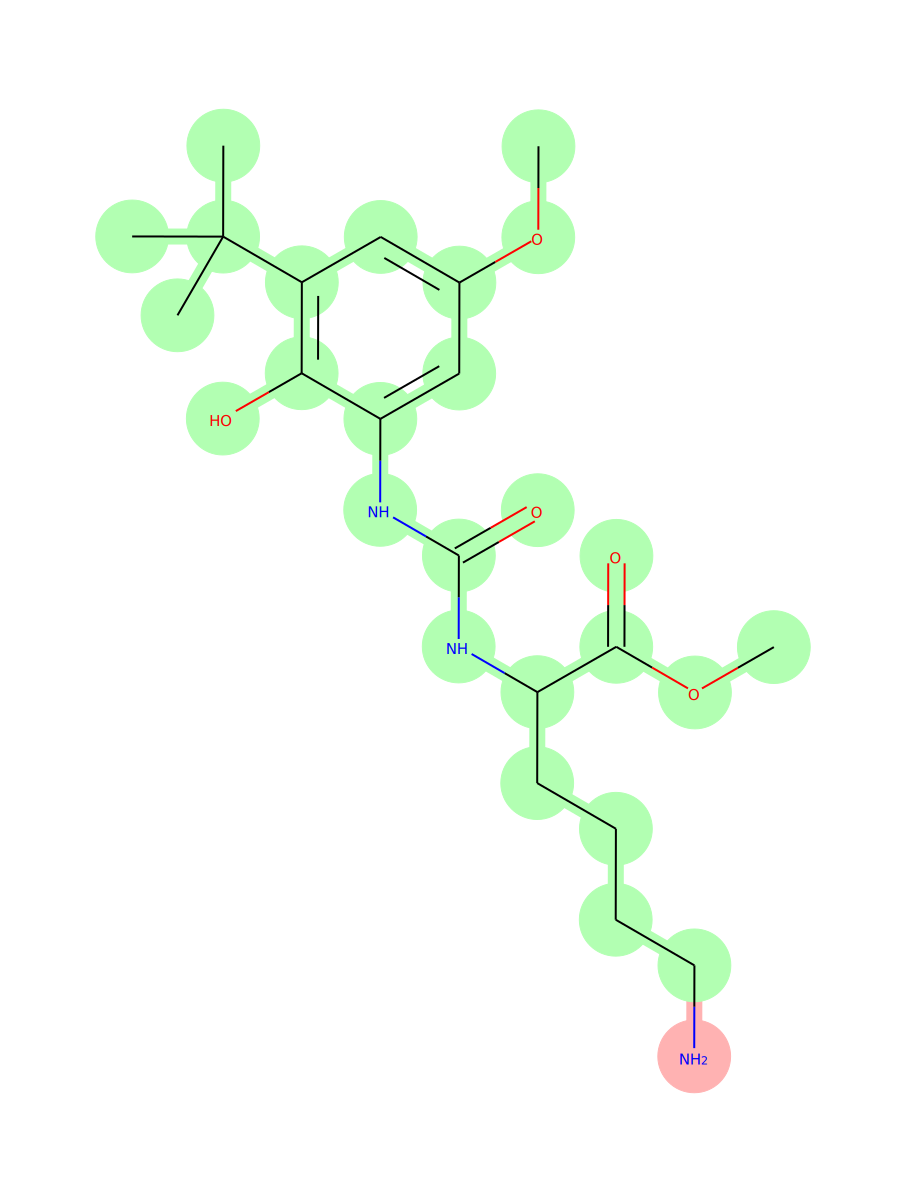

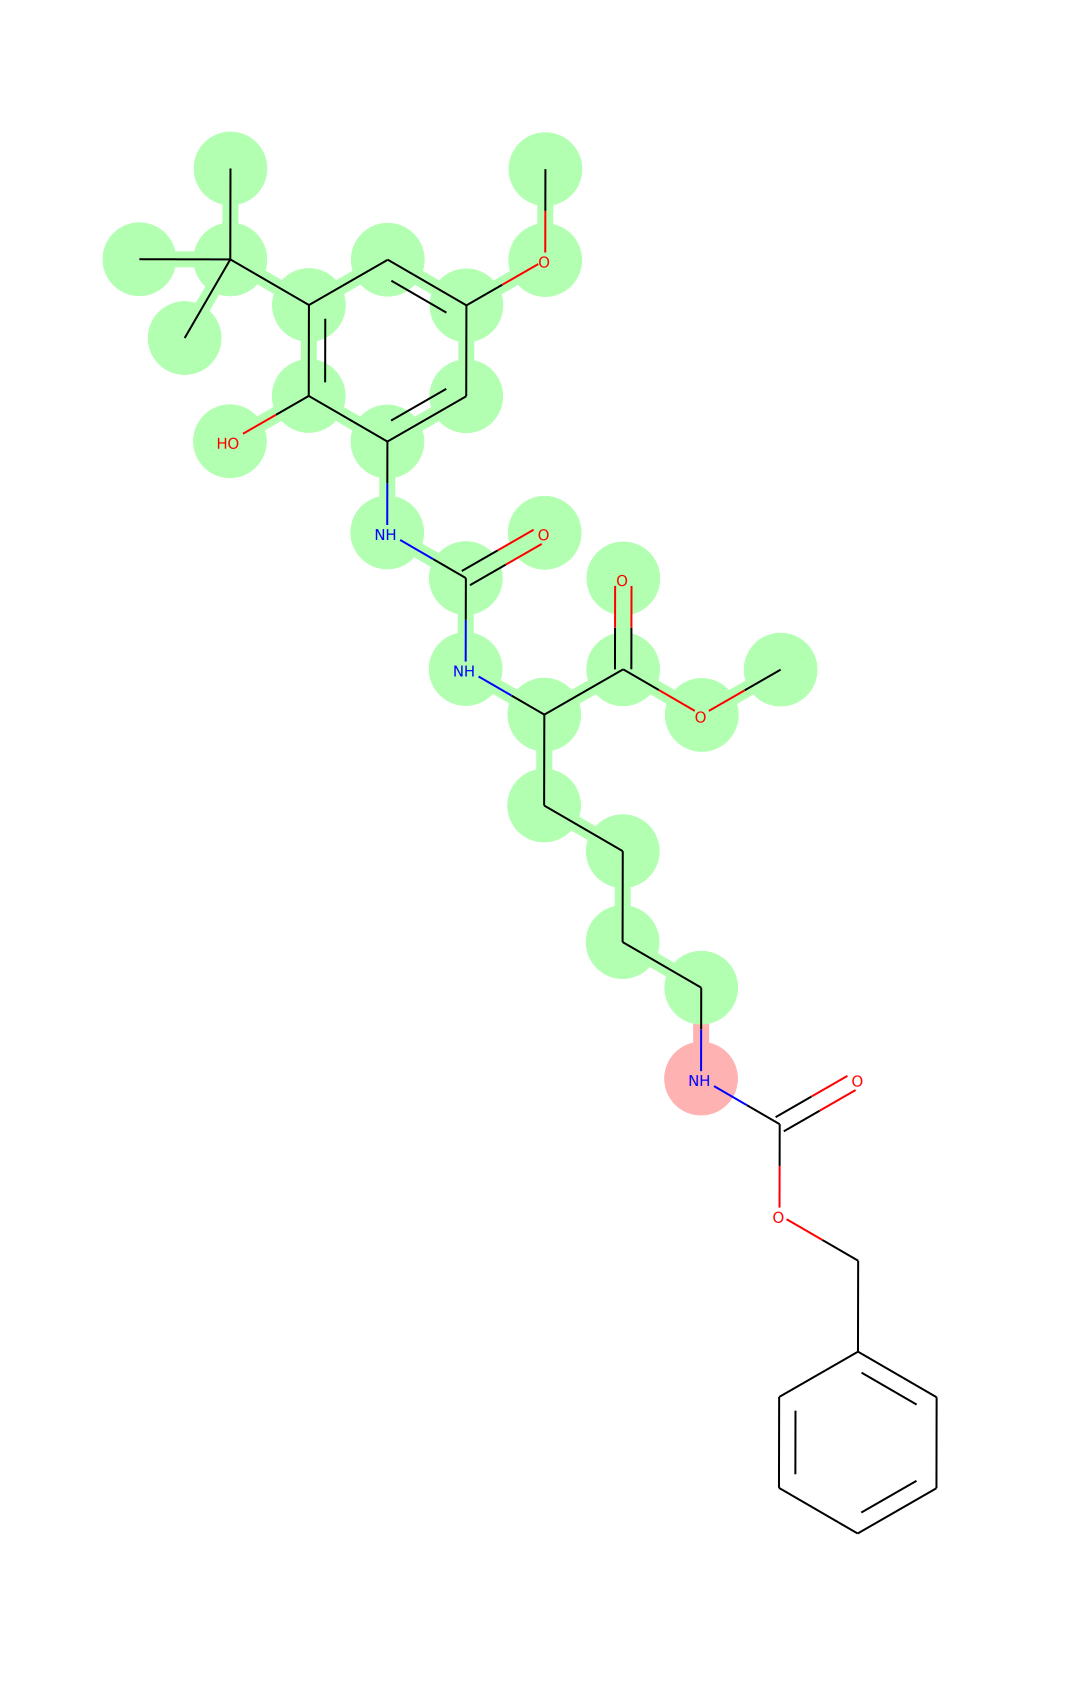

859
0.09541643


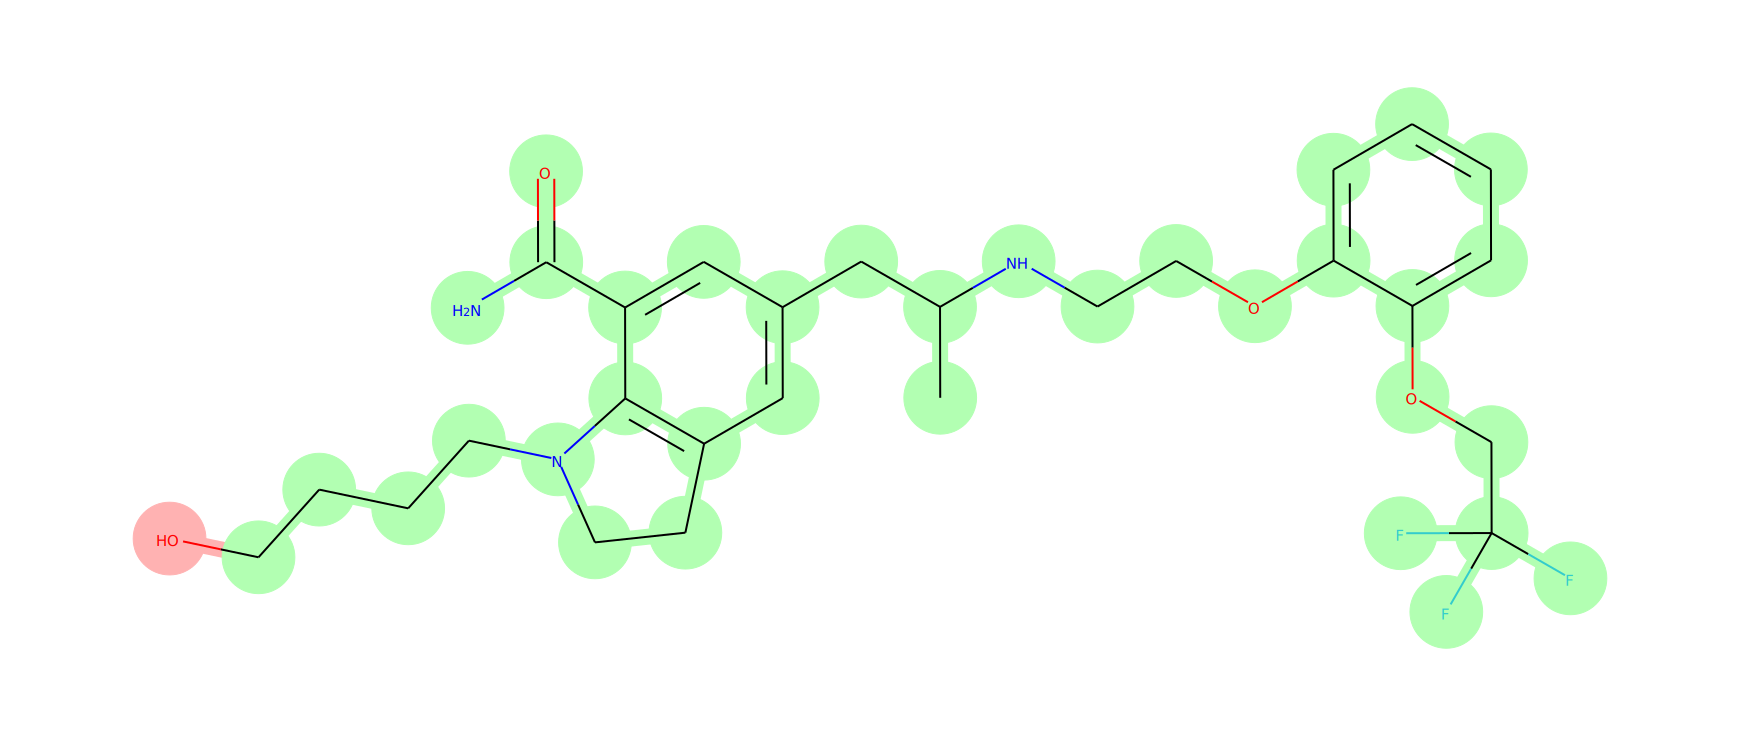

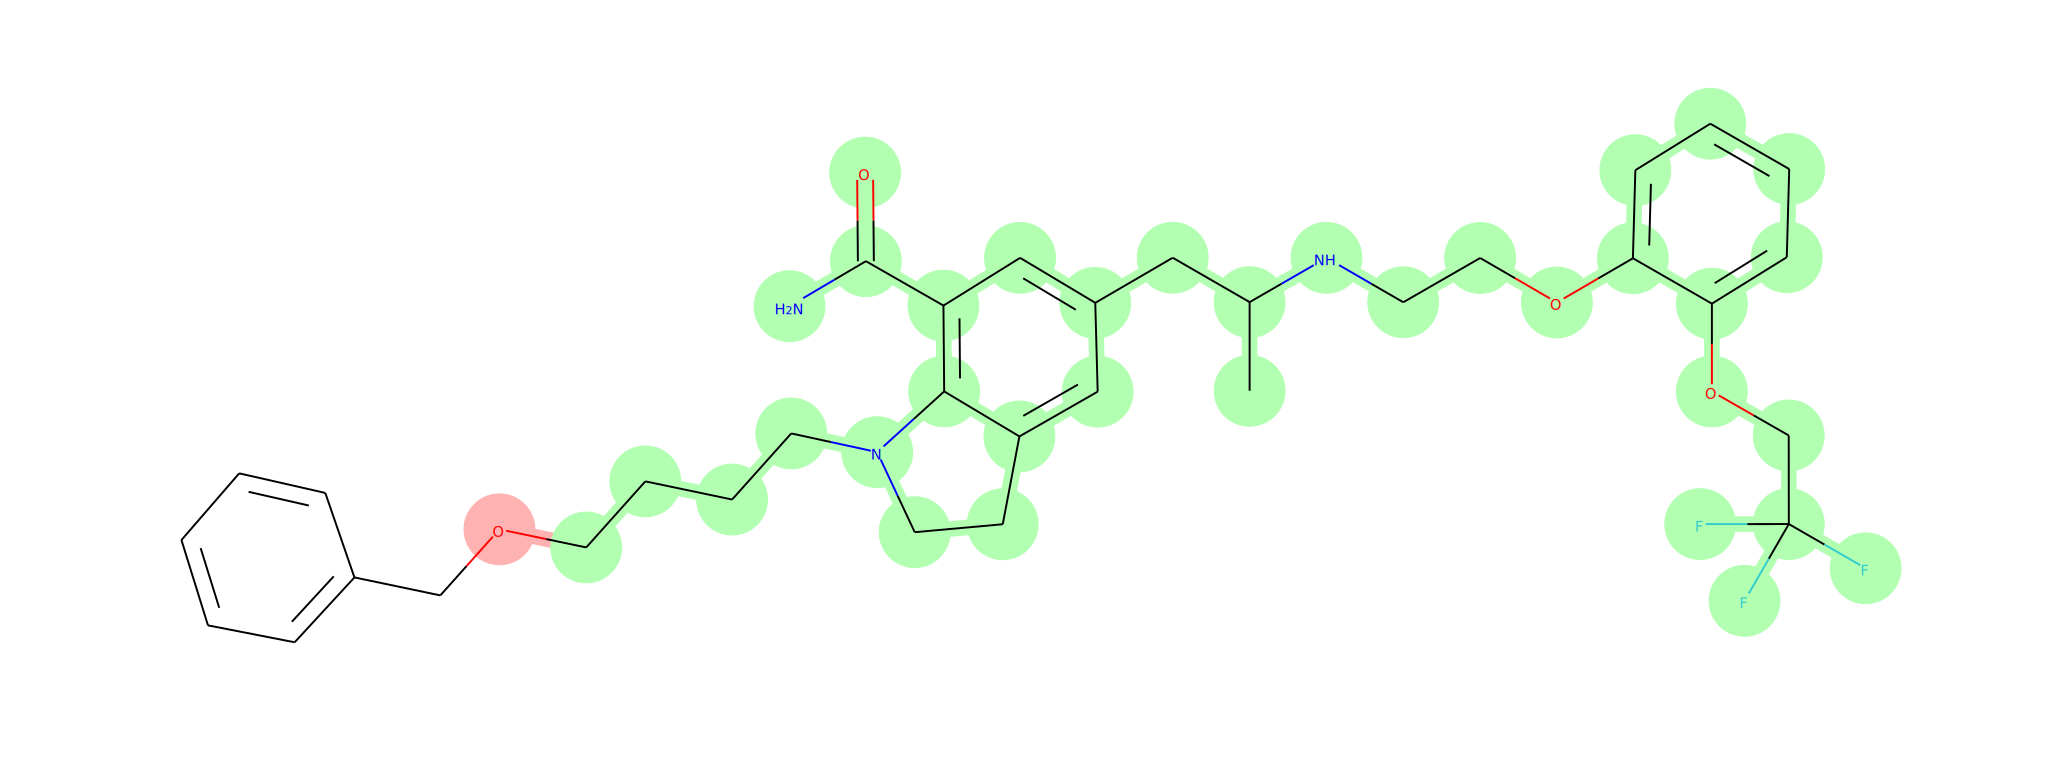

6720
0.0982145


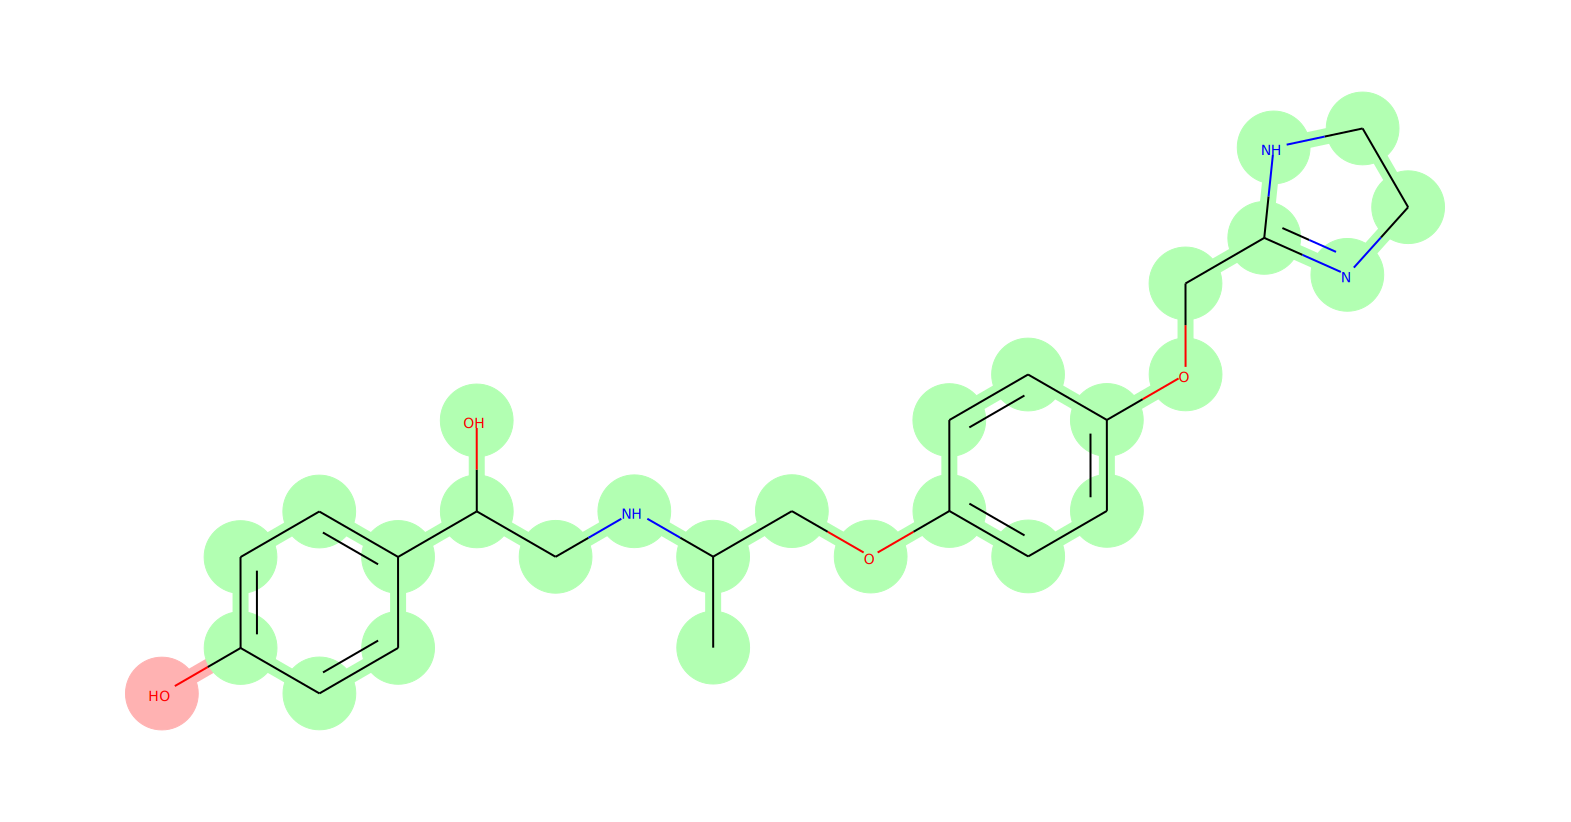

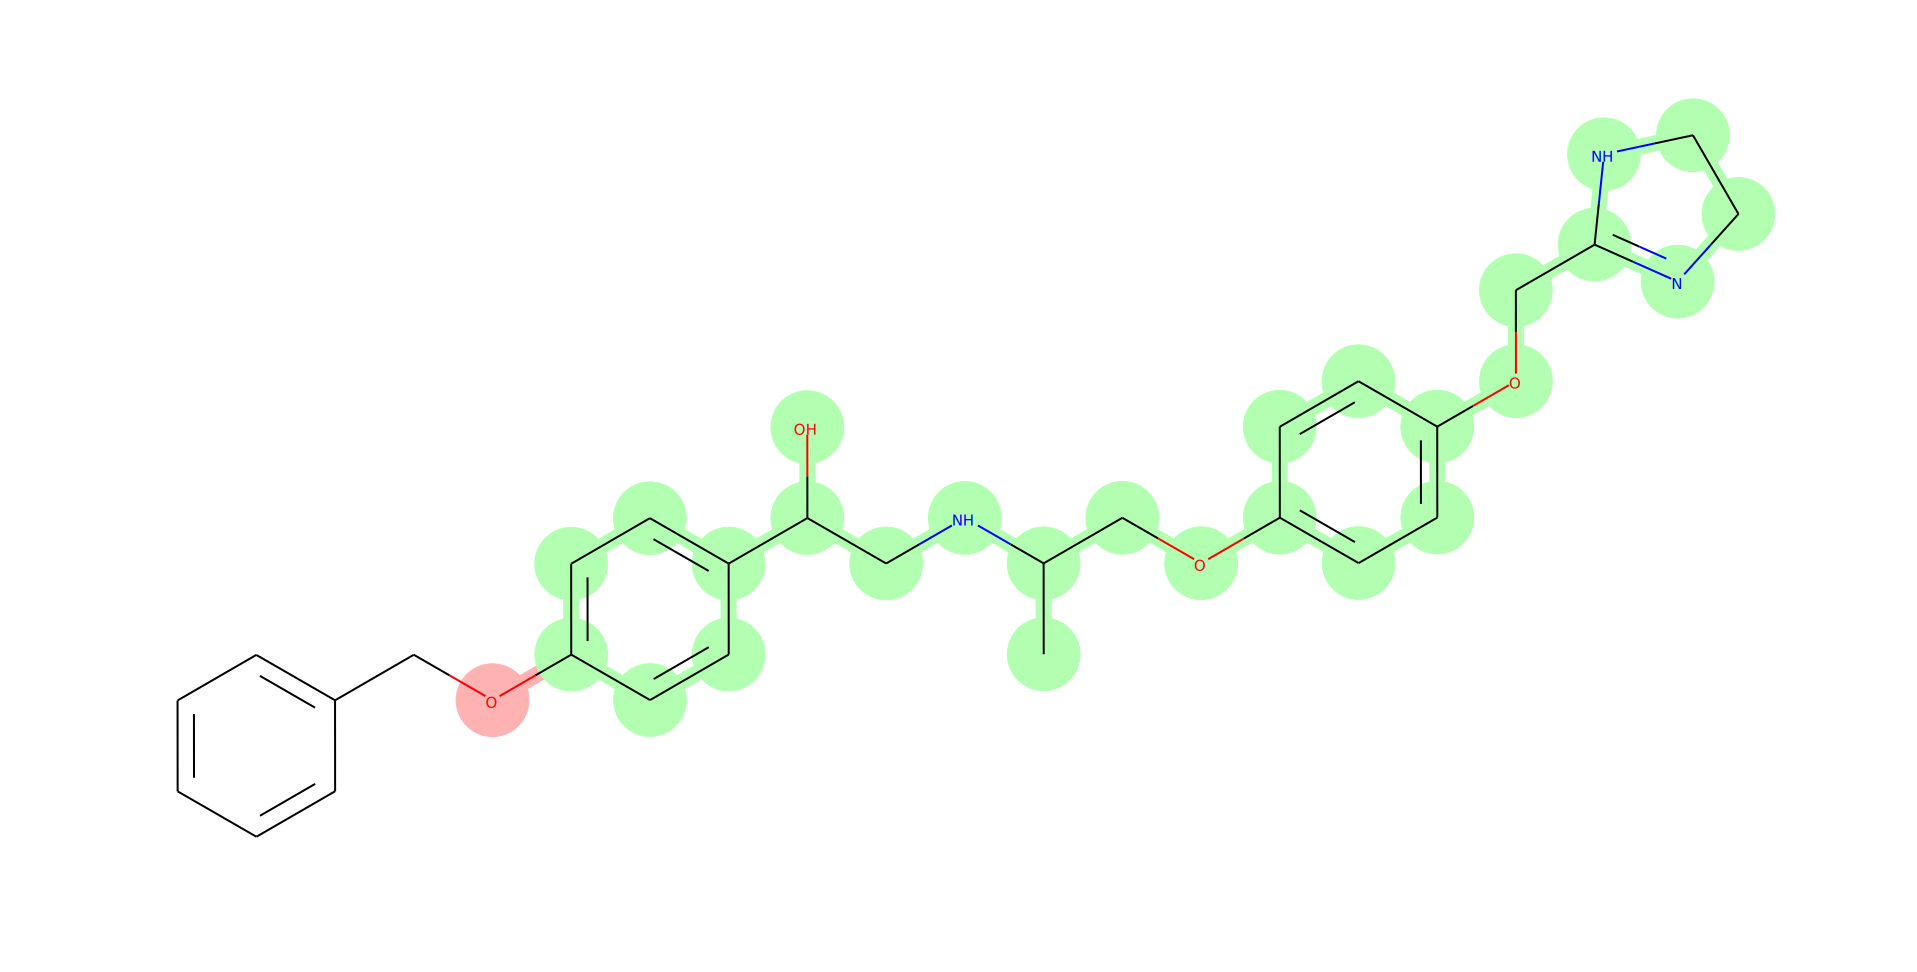

5951
0.17082532


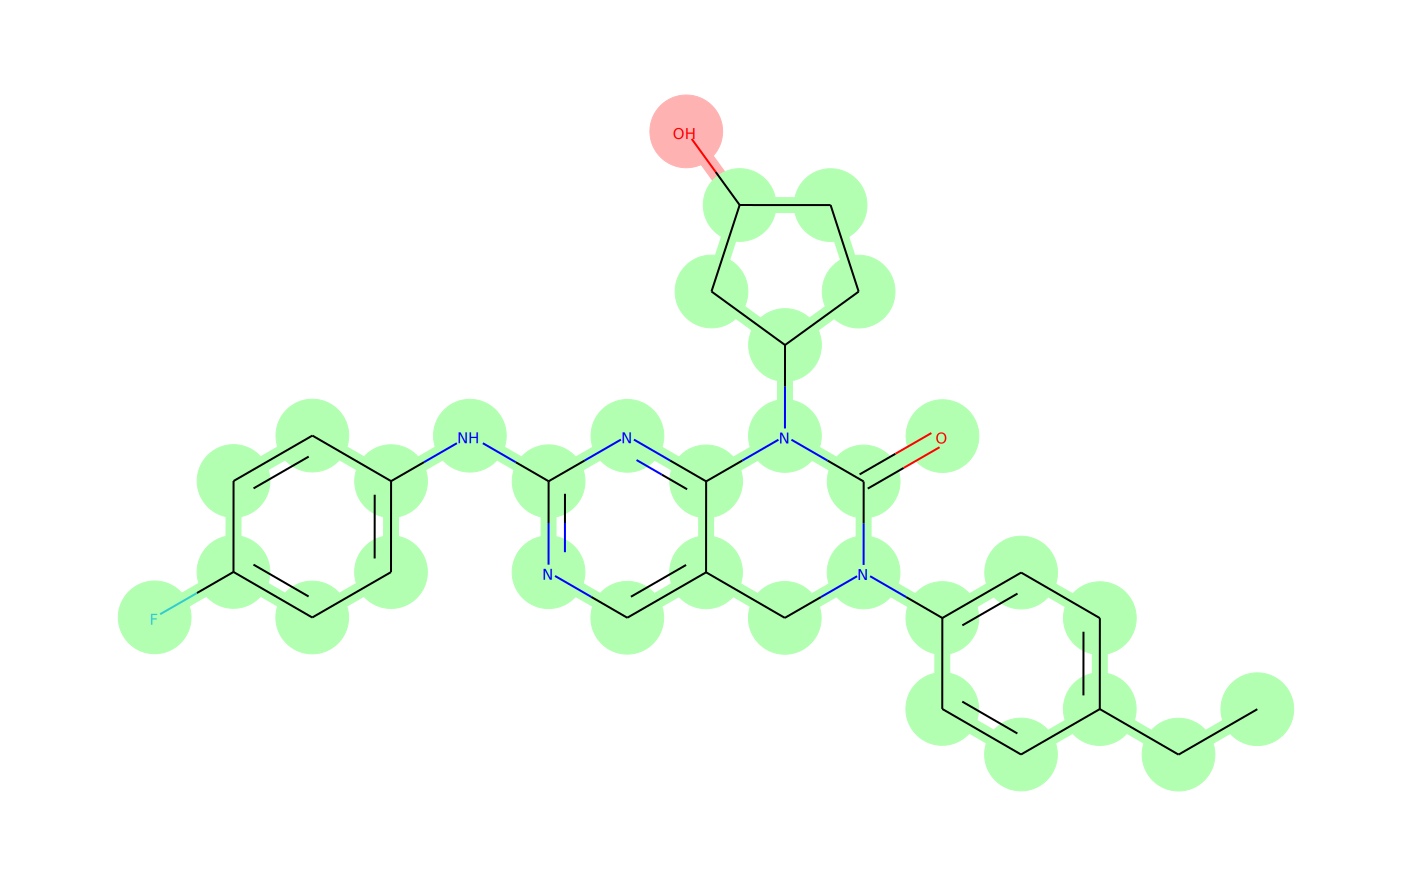

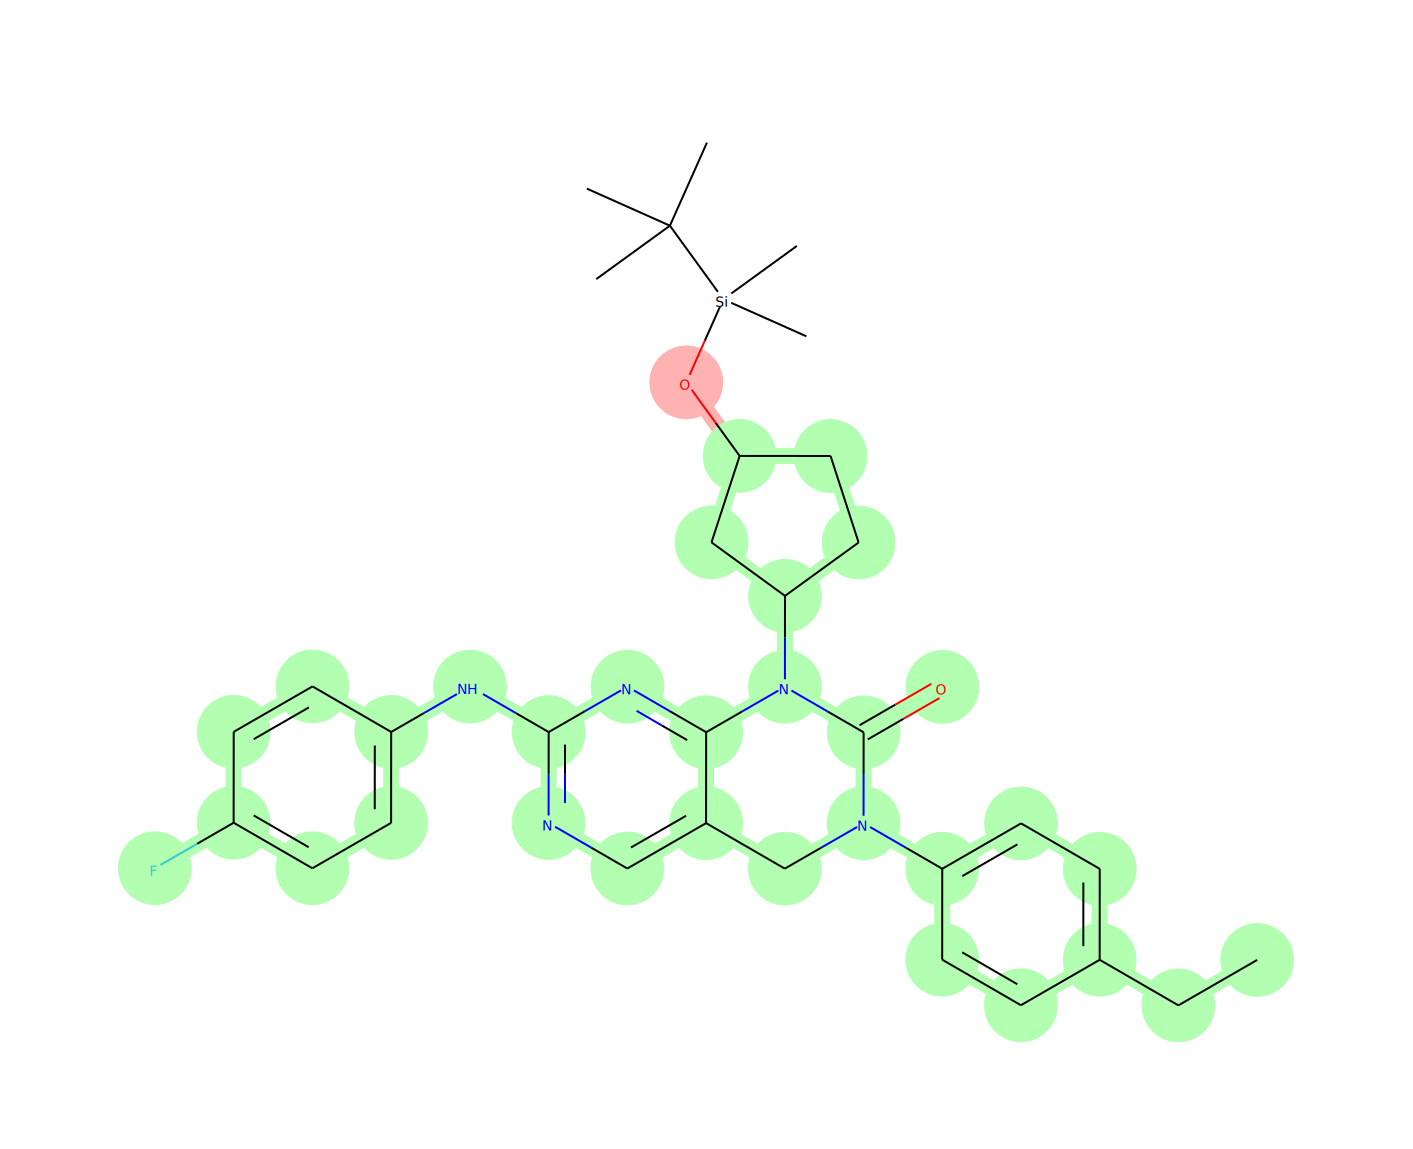

5938
0.64683867


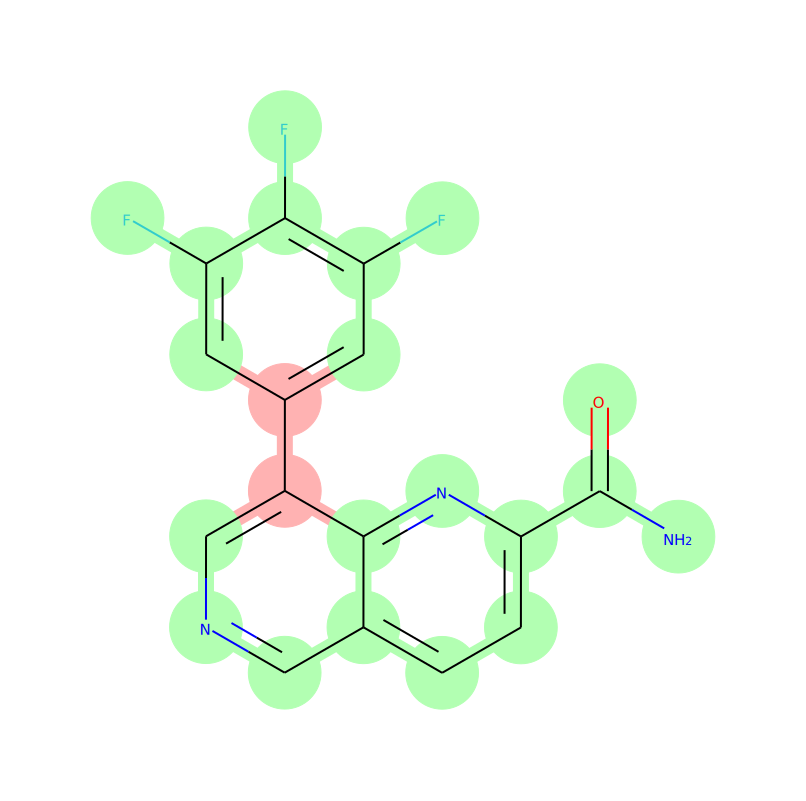

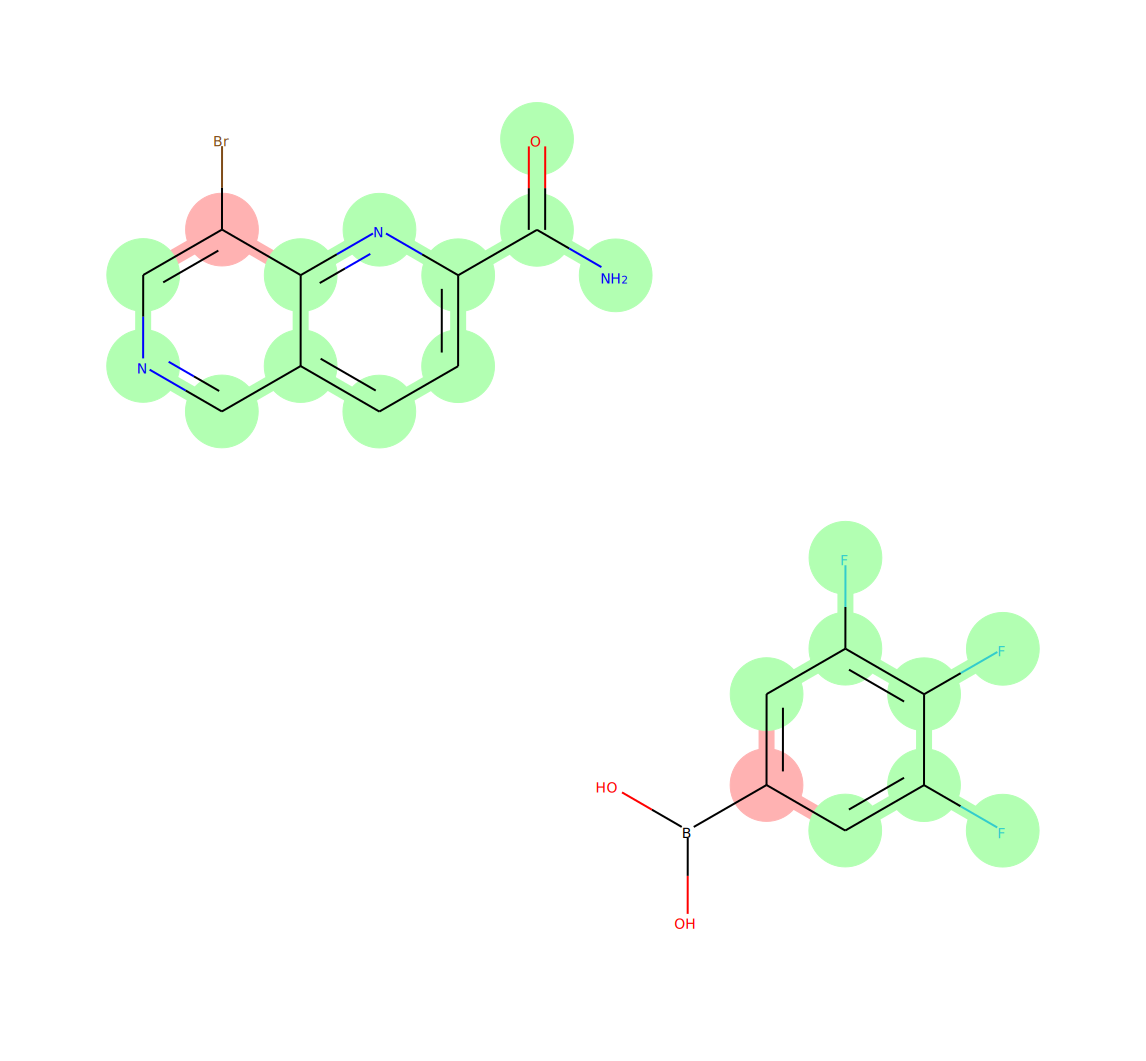

In [39]:
idx = 0
norms = np.linalg.norm(reac_reps - reac_reps[idx], axis=-1)
norms = np.array(norms)
idxs = np.argsort(norms)
show_k_reactants(test_dataset, norms, idxs[[0, 1, 2, 50, 5002]])